In [51]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import os
from pathlib import Path
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [53]:
base_dir = r"C:\Users\user\Desktop\DL"
test_dir  = os.path.join(base_dir, "test")

# Validation and Test transforms for no randomness, cvonsistent evaluation
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)
class_names = test_dataset.classes
num_classes = len(class_names)  # your class_names list

batch_size = 32 # num_workers=2 for parallel data loading
loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [66]:
def load_model(model_name, num_classes, checkpoint_path):
    if model_name == "resnet50":
        model = models.resnet50(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=None)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(weights=None)
        num_ftrs = model.classifier.in_features
        # Match your trained architecture exactly (Dropout + Linear)
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_ftrs, num_classes)
        )
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v3_large(weights=None)
        try:
            num_ftrs = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        except:
            num_ftrs = model.classifier[0].in_features
            model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError(f"Model '{model_name}' not supported")

    checkpoint = torch.load(checkpoint_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint, strict=False)

    model.to(device)
    model.eval()
    print(f"✅ Loaded {model_name} from {checkpoint_path}")
    return model

In [67]:
def evaluate_model(model, loader, class_names):
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    
    return acc, f1

In [68]:
models_checkpoints = {
    "resnet50": "ResNet50_Finetuned_best.pth",
    "efficientnet_b0": "EfficientNet-B0_best.pth",
    "mobilenet_v2": "MobileNetV3-Large_best.pth",
    "densenet121": "final_skin_disease_model.pth",
}


Evaluating resnet50...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\3653341792.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

✅ Loaded resnet50 from ResNet50_Finetuned_best.pth

Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.94      0.92        88
             Chickenpox       0.94      0.97      0.96       113
                 Cowpox       0.97      0.98      0.97        99
         Dermatofibroma       1.00      0.76      0.86        25
                   HFMD       0.96      0.99      0.97       242
                Healthy       0.98      0.98      0.98       171
                Measles       0.96      0.98      0.97        83
              Monkeypox       0.99      0.96      0.97       426
Squamous cell carcinoma       0.89      0.88      0.88        64
       Vascular lesions       0.93      1.00      0.96        26

               accuracy                           0.96      1337
              macro avg       0.95      0.94      0.94      1337
           weighted avg       0.96      0.96      0.96      1337



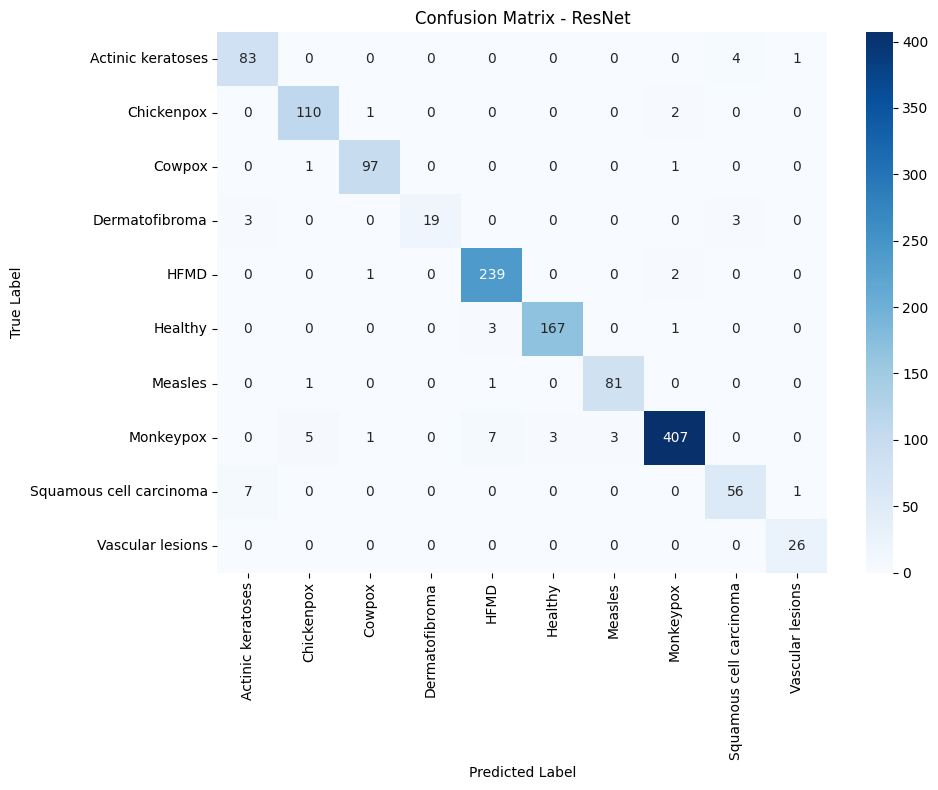


Evaluating efficientnet_b0...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\3653341792.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

✅ Loaded efficientnet_b0 from EfficientNet-B0_best.pth

Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.88      0.88        88
             Chickenpox       0.94      1.00      0.97       113
                 Cowpox       0.98      1.00      0.99        99
         Dermatofibroma       1.00      0.92      0.96        25
                   HFMD       0.99      1.00      0.99       242
                Healthy       0.98      0.99      0.99       171
                Measles       0.98      0.98      0.98        83
              Monkeypox       1.00      0.97      0.98       426
Squamous cell carcinoma       0.84      0.88      0.85        64
       Vascular lesions       1.00      1.00      1.00        26

               accuracy                           0.97      1337
              macro avg       0.96      0.96      0.96      1337
           weighted avg       0.97      0.97      0.97      1337



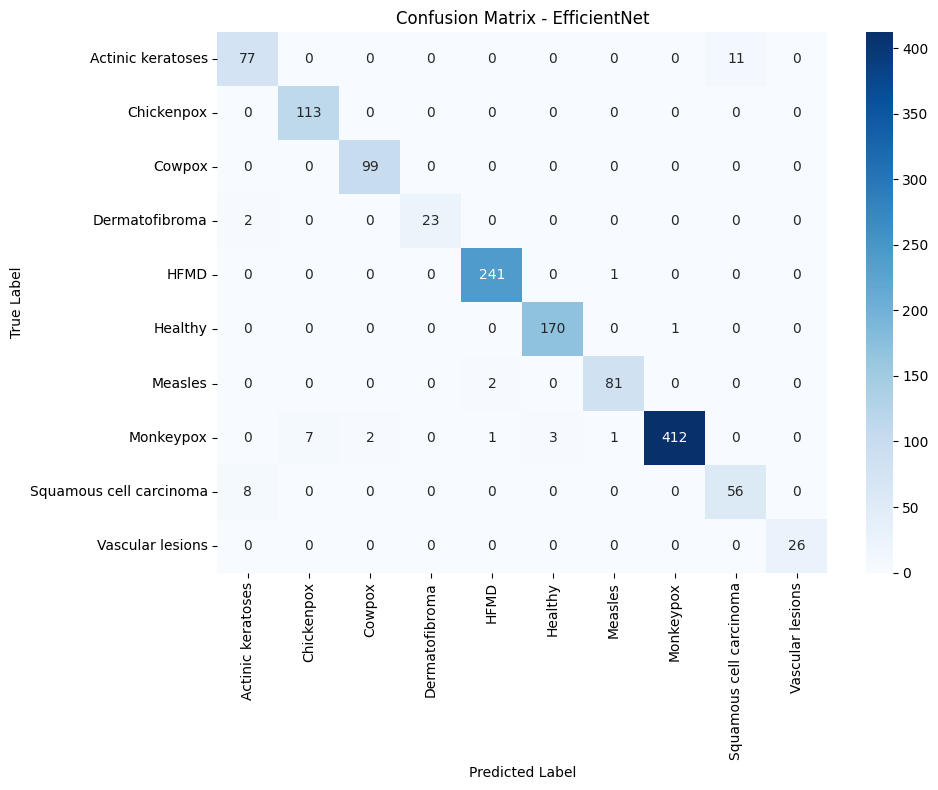


Evaluating mobilenet_v2...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\3653341792.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

✅ Loaded mobilenet_v2 from MobileNetV3-Large_best.pth

Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.82      0.85        88
             Chickenpox       0.92      0.98      0.95       113
                 Cowpox       0.99      0.98      0.98        99
         Dermatofibroma       0.95      0.80      0.87        25
                   HFMD       0.95      1.00      0.97       242
                Healthy       1.00      0.95      0.97       171
                Measles       0.96      0.99      0.98        83
              Monkeypox       0.99      0.96      0.98       426
Squamous cell carcinoma       0.78      0.92      0.84        64
       Vascular lesions       1.00      0.96      0.98        26

               accuracy                           0.96      1337
              macro avg       0.94      0.94      0.94      1337
           weighted avg       0.96      0.96      0.96      1337



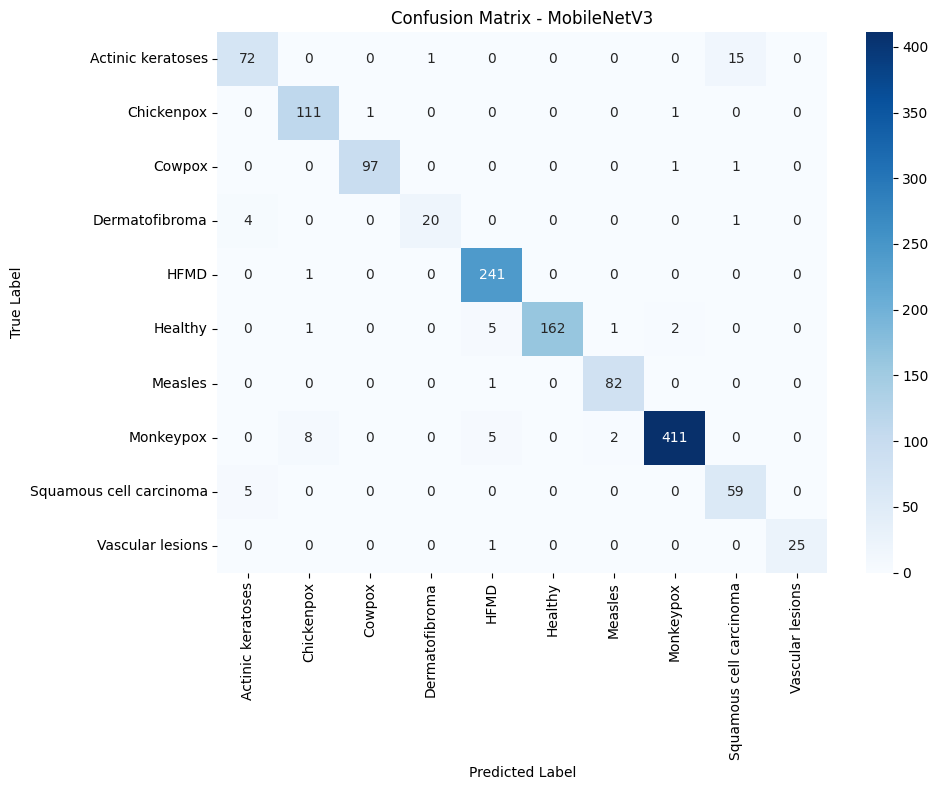


Evaluating densenet121...


C:\Users\user\AppData\Local\Temp\ipykernel_5768\3653341792.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

✅ Loaded densenet121 from final_skin_disease_model.pth

Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.88      0.76      0.82        88
             Chickenpox       0.83      0.97      0.90       113
                 Cowpox       0.91      0.98      0.94        99
         Dermatofibroma       0.96      0.88      0.92        25
                   HFMD       0.99      0.94      0.96       242
                Healthy       0.91      0.99      0.95       171
                Measles       0.93      0.94      0.93        83
              Monkeypox       0.98      0.90      0.94       426
Squamous cell carcinoma       0.73      0.88      0.79        64
       Vascular lesions       0.96      1.00      0.98        26

               accuracy                           0.93      1337
              macro avg       0.91      0.92      0.91      1337
           weighted avg       0.93      0.93      0.93      1337



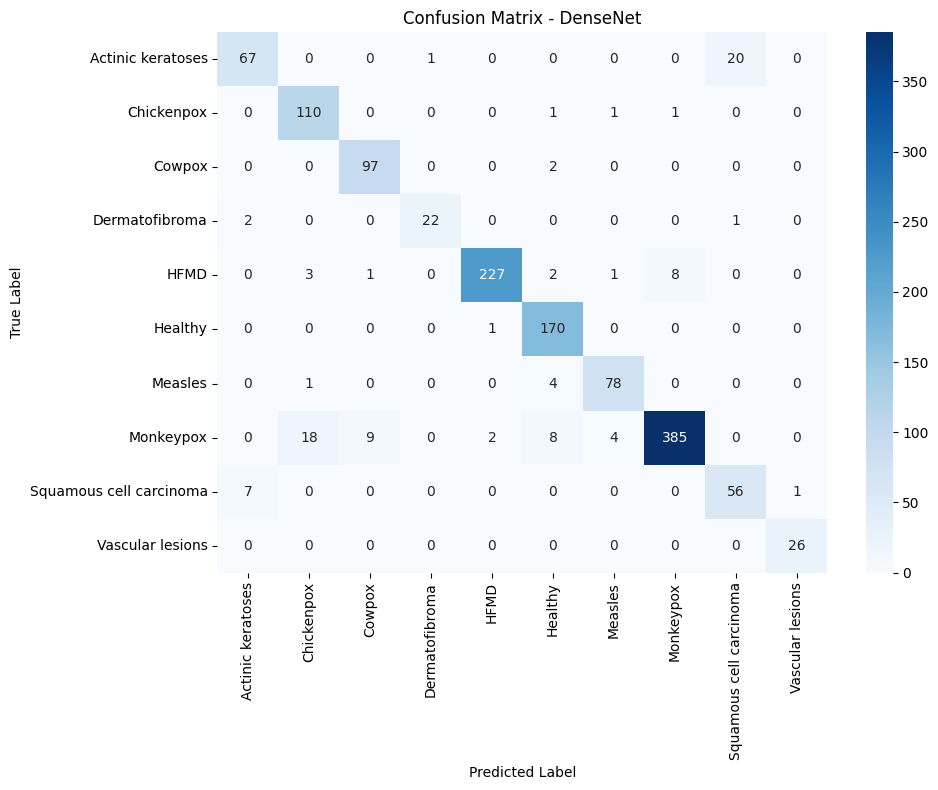

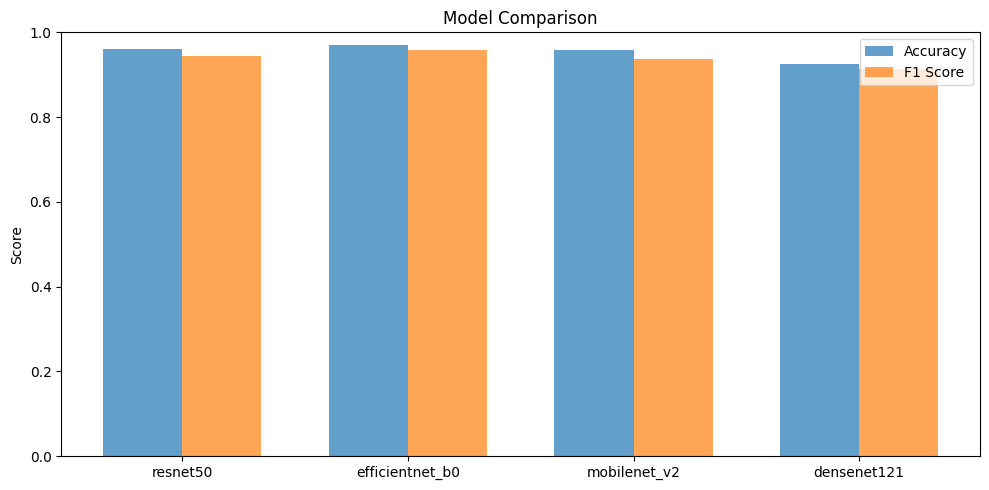

In [69]:
results = {}

for model_name, ckpt in models_checkpoints.items():
    print(f"\nEvaluating {model_name}...")
    model = load_model(model_name, num_classes, ckpt)
    acc, f1 = evaluate_model(model, loader, class_names)
    results[model_name] = {"accuracy": acc, "f1": f1}

names = list(results.keys())
accs = [results[m]["accuracy"] for m in names]
f1s  = [results[m]["f1"] for m in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accs, width, label="Accuracy", alpha=0.7)
plt.bar(x + width/2, f1s, width, label="F1 Score", alpha=0.7)
plt.xticks(x, names)
plt.ylabel("Score")
plt.title("Model Comparison")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

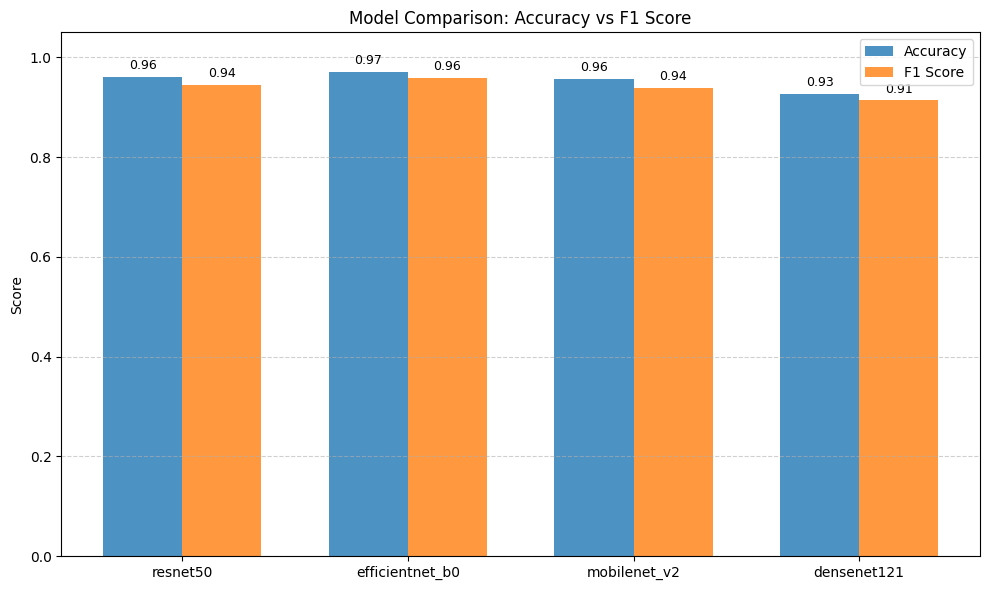

In [70]:
import matplotlib.pyplot as plt
import numpy as np

names = list(results.keys())
accs = [results[m]["accuracy"] for m in names]
f1s  = [results[m]["f1"] for m in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, accs, width, label='Accuracy', alpha=0.8)
bars2 = plt.bar(x + width/2, f1s, width, label='F1 Score', alpha=0.8)

# Annotate each bar with its value
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 0.01, 
            f"{bar.get_height():.2f}", 
            ha='center', va='bottom', fontsize=9
        )

plt.xticks(x, names)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


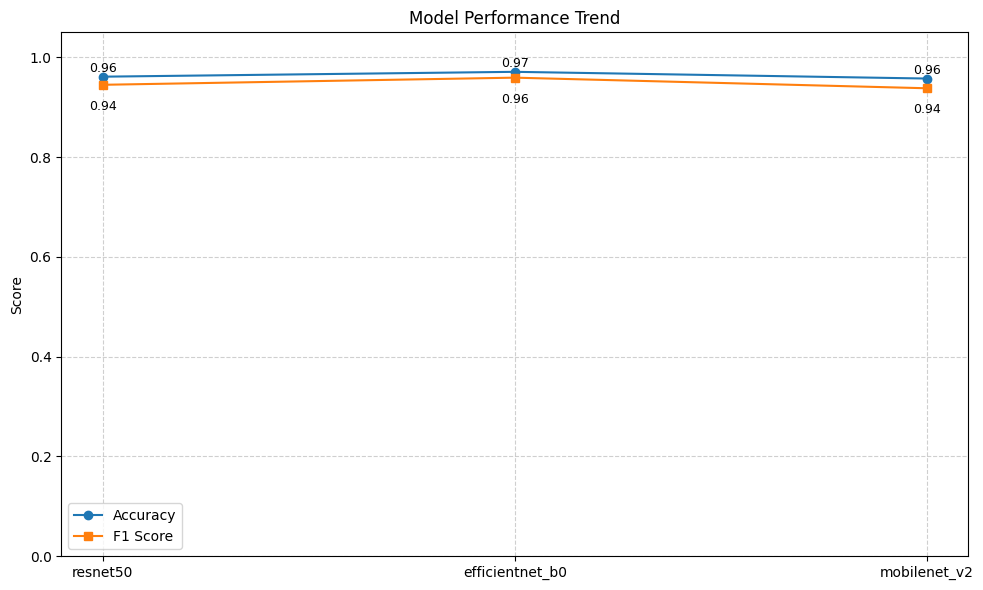

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(names, accs, marker='o', label='Accuracy')
plt.plot(names, f1s, marker='s', label='F1 Score')

for i, val in enumerate(accs):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', fontsize=9)
for i, val in enumerate(f1s):
    plt.text(i, val - 0.05, f"{val:.2f}", ha='center', fontsize=9)

plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Performance Trend")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


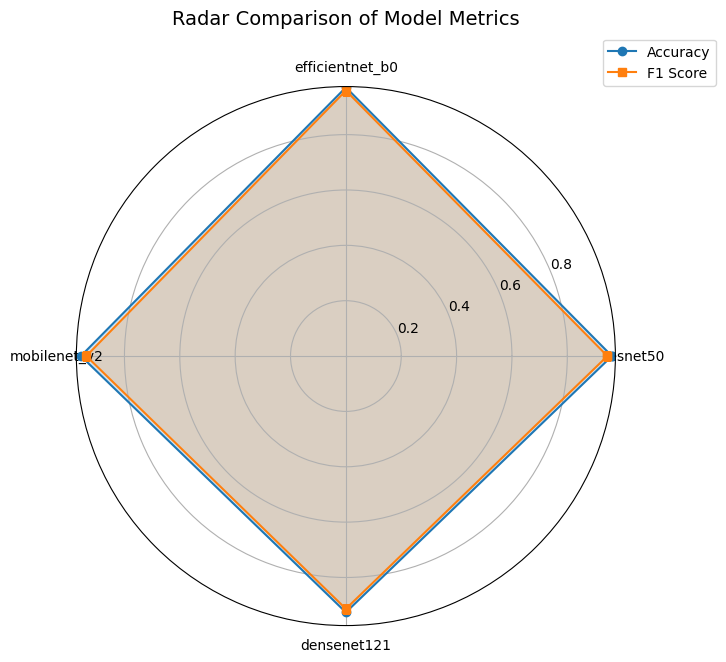

In [71]:
from math import pi

categories = list(results.keys())
N = len(categories)

values_acc = [results[m]["accuracy"] for m in categories]
values_f1  = [results[m]["f1"] for m in categories]
values_acc += values_acc[:1]
values_f1  += values_f1[:1]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
plt.polar(angles, values_acc, marker='o', label="Accuracy")
plt.polar(angles, values_f1, marker='s', label="F1 Score")

plt.fill(angles, values_acc, alpha=0.2)
plt.fill(angles, values_f1, alpha=0.2)

plt.xticks(angles[:-1], categories)
plt.title("Radar Comparison of Model Metrics", size=14, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


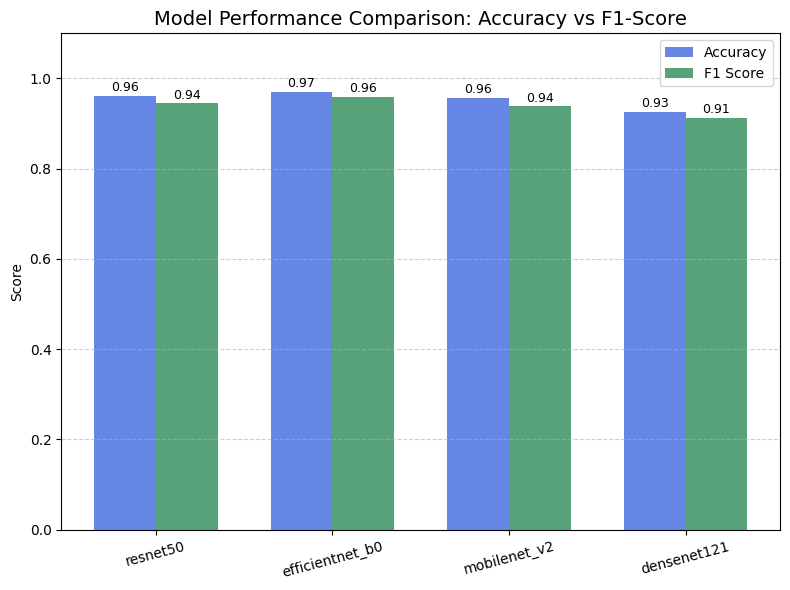

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your results dict looks like this:
# results = {
#     "ResNet50": {"accuracy": 0.89, "f1": 0.87},
#     "EfficientNet-B0": {"accuracy": 0.91, "f1": 0.88},
#     "DenseNet121": {"accuracy": 0.90, "f1": 0.89},
#     "MobileNetV3-Large": {"accuracy": 0.88, "f1": 0.86}
# }

categories = list(results.keys())
accuracy = [results[m]["accuracy"] for m in categories]
f1_scores = [results[m]["f1"] for m in categories]

x = np.arange(len(categories))  # model indices
width = 0.35  # bar width

plt.figure(figsize=(8,6))
plt.bar(x - width/2, accuracy, width, label='Accuracy', color='royalblue', alpha=0.8)
plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='seagreen', alpha=0.8)

# Add text labels above bars
for i in range(len(categories)):
    plt.text(x[i] - width/2, accuracy[i] + 0.01, f"{accuracy[i]:.2f}", ha='center', fontsize=9)
    plt.text(x[i] + width/2, f1_scores[i] + 0.01, f"{f1_scores[i]:.2f}", ha='center', fontsize=9)

plt.xticks(x, categories, rotation=15)
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("Model Performance Comparison: Accuracy vs F1-Score", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [73]:
for model_name, vals in results.items():
    results[model_name]["misclassified"] = int(vals["total"] * (1 - vals["accuracy"]))

KeyError: 'total'

In [74]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
misclassified = [results[m]["misclassified"] for m in models]
correct = [results[m]["total"] - results[m]["misclassified"] for m in models]

x = np.arange(len(models))
width = 0.4

plt.figure(figsize=(8,6))
bars1 = plt.bar(x - width/2, correct, width, label='Correctly Classified', color='seagreen', alpha=0.8)
bars2 = plt.bar(x + width/2, misclassified, width, label='Misclassified', color='indianred', alpha=0.8)

# Add counts above bars
for i in range(len(models)):
    plt.text(x[i] - width/2, correct[i] + 5, f"{correct[i]}", ha='center', fontsize=9)
    plt.text(x[i] + width/2, misclassified[i] + 5, f"{misclassified[i]}", ha='center', fontsize=9)

plt.xticks(x, models, rotation=15)
plt.ylabel("Number of Images")
plt.title("Model Comparison: Correct vs Misclassified Images", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


KeyError: 'misclassified'